In [26]:
import findspark
findspark.init()

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql import *
from pyspark.sql.window import Window

import pickle
from datetime import datetime, timedelta, date
from time import time
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import sys
import os

#Need to set environment variables in order to make pyspark work in Python3.6
spark_home=os.environ['SPARK_HOME']
os.environ['PYTHONPATH']= spark_home+"/python/lib/py4j-0.10.4-src.zip"
os.environ['PYSPARK_PYTHON']="/dfm0/util/dfm_python/python36/bin/python3.6"
os.environ['PYSPARK_DRIVER_PYTHON']="/dfm0/util/dfm_python/python36/bin/python3.6"

super_dir='/dfm1/lijli06/DFM_SPARK'

In [3]:
spark = SparkSession.builder \
            .master("yarn") \
            .appName("data_exploration_linhai") \
            .config("spark.executor.instances", 17) \
            .config("spark.executor.cores",5) \
            .config("spark.executor.memory",'29G') \
            .config("spark.submit.deployMode",'client') \
            .getOrCreate()

In [4]:
start_date="2018-07-01"
end_date="2018-07-07"
log_label="sysauditlog"

#convert the dates from string to date objects
start_date1 = datetime.strptime(start_date, '%Y-%m-%d').date()
end_date1 = datetime.strptime(end_date, '%Y-%m-%d').date()

#Get the paths to the hdfs files; end date may be extended one day later
tmp_paths = []

if log_label in ['aracslog', 'arvelog', 'areslog', 'aracsstat']:
    path_label = log_label + '/*'
else:
    path_label = log_label

date_delta = end_date1 - start_date1
path_dates = [start_date1+relativedelta(days=i) for i in range(date_delta.days+1)]
for path_date in path_dates:
    tmp_path = "hdfs://dfm-cluster/DFM/"+path_label+"/" \
                +"/".join(path_date.strftime("%Y-%m-%d").split("-")) \
                +"/"+log_label+".avro"
    tmp_paths.append(tmp_path)

tmp_df=spark.read.format("com.databricks.spark.avro").load(tmp_paths)
        
#tmp_df.columns

In [5]:
orgs = pd.read_csv('/dfm1/lijli06/DFM_SPARK/HSBC_Group.txt',header=0)
tmp_df = tmp_df.filter(tmp_df.ORGNAME.isin(orgs['ORGNAME'].tolist()) & (tmp_df.ISSUERCOUNTRY != '') & (tmp_df.ISSUERCOUNTRY.isNotNull()))
tmp_df = tmp_df.select('ORGNAME', 'USERNAME', 'ISSUERCOUNTRY', 'AMOUNTUSD')
# tmp_df.take(1)

In [6]:
#Calculate the median AMOUNTUSD using high level api
med1_time = []
for i in range(10):
    start = time()
    agg_func = F.expr('percentile_approx({}, 0.5, 500)'.format('AMOUNTUSD'))
    tmp_list = tmp_df.groupby('ORGNAME').pivot('ISSUERCOUNTRY').agg(agg_func).fillna(0)
    columns = tmp_list.columns
    tmp_list = tmp_list.rdd.map(list).collect()
    result = pd.DataFrame(tmp_list, columns=columns)
    end = time()
    print("Used time of {:.2f} sec".format(end - start))
    med1_time.append(end-start)
    #result

Used time of 36.15 sec
Used time of 27.82 sec
Used time of 77.77 sec
Used time of 26.25 sec
Used time of 38.33 sec
Used time of 25.40 sec
Used time of 25.97 sec
Used time of 24.57 sec
Used time of 75.25 sec
Used time of 27.27 sec


In [7]:
#Calculate the median AMOUNTUSD using low level api
med2_time = []
for i in range(10):
    start = time()
    tmp_list = tmp_df.rdd.map(lambda x: ((x.ORGNAME, x.ISSUERCOUNTRY), x.AMOUNTUSD)) \
                     .combineByKey(lambda x: [x], lambda x,y: x+[y], lambda x,y: x+y) \
                     .mapValues(lambda x: np.median(x)).map(lambda x: [x[0][0], x[0][1], x[1]]).collect()
    result = pd.DataFrame(tmp_list, columns=['ORGNAME', 'ISSUERCOUNTRY', 'Value'])
    result = pd.pivot_table(result, index='ORGNAME', columns='ISSUERCOUNTRY', values='Value', fill_value=0).reset_index()
    end = time()
    print("Used time of {:.2f} sec".format(end - start))
    med2_time.append(end-start)
    #result

Used time of 147.32 sec
Used time of 169.31 sec
Used time of 156.49 sec
Used time of 224.43 sec
Used time of 69.49 sec
Used time of 145.10 sec
Used time of 144.03 sec
Used time of 69.92 sec
Used time of 143.44 sec
Used time of 143.15 sec


In [8]:
#Calculate the median AMOUNTUSD using window function
med3_time = []
for i in range(10):
    start = time()
    w = Window.partitionBy(['ORGNAME', 'ISSUERCOUNTRY']).orderBy('AMOUNTUSD')
    df = tmp_df.withColumn('rn', F.row_number().over(w)).withColumn('MedIdx', F.count('rn').over(w.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing))/2)
    df = df.withColumn('filter', F.when(F.ceil('MedIdx')==F.floor('MedIdx'), \
                                                    F.when((F.col('rn')==F.col('MedIdx')) | (F.col('rn')==F.col('MedIdx')), True).otherwise(False)) \
                                                    .otherwise(F.when(F.col('rn')==F.ceil('MedIdx'), True).otherwise(False)))
    df = df.filter('filter').drop('rn', 'MedIdx', 'filter')
    df = df.select('ORGNAME', 'ISSUERCOUNTRY', 'AMOUNTUSD').withColumn('Value', F.mean('AMOUNTUSD').over(w.rowsBetween(-2, 2))).withColumn('rn', F.row_number().over(w)).filter(F.col('rn') == 1).drop('rn')                      
    tmp_list = df.rdd.map(lambda x: [x['ORGNAME'], x['ISSUERCOUNTRY'], x['Value']]).collect()
    result = pd.DataFrame(tmp_list, columns=['ORGNAME', 'ISSUERCOUNTRY', 'Value'])
    result = pd.pivot_table(result, index='ORGNAME', columns='ISSUERCOUNTRY', values='Value', fill_value=0).reset_index()
    end = time()
    print("Used time of {:.2f} sec".format(end - start))
    med3_time.append(end-start)
    #result

Used time of 152.05 sec
Used time of 151.23 sec
Used time of 117.07 sec
Used time of 193.54 sec
Used time of 240.85 sec
Used time of 138.35 sec
Used time of 240.77 sec
Used time of 115.72 sec
Used time of 163.43 sec
Used time of 146.62 sec


In [10]:
#Calculate the median AMOUNTUSD using window function + low level
med4_time = []
for i in range(10):
    start = time()
    w = Window.partitionBy(['ORGNAME', 'ISSUERCOUNTRY']).orderBy('AMOUNTUSD')
    df = tmp_df.withColumn('rn', F.row_number().over(w)).withColumn('MedIdx', F.count('rn').over(w.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing))/2)
    df = df.withColumn('filter', F.when(F.ceil('MedIdx')==F.floor('MedIdx'), \
                                                    F.when((F.col('rn')==F.col('MedIdx')) | (F.col('rn')==F.col('MedIdx')), True).otherwise(False)) \
                                                    .otherwise(F.when(F.col('rn')==F.ceil('MedIdx'), True).otherwise(False)))
    df = df.filter('filter').drop('rn', 'MedIdx', 'filter')
    tmp_list = df.rdd.map(lambda x: ((x.ORGNAME, x.ISSUERCOUNTRY), [x.AMOUNTUSD, 1])) \
                     .reduceByKey(lambda x,y: [x[0]+y[0], x[1]+y[1]]).mapValues(lambda x: x[0]/x[1]) \
                     .map(lambda x: [x[0][0], x[0][1], x[1]]).collect()
    result = pd.DataFrame(tmp_list, columns=['ORGNAME', 'ISSUERCOUNTRY', 'Value'])
    result = pd.pivot_table(result, index='ORGNAME', columns='ISSUERCOUNTRY', values='Value', fill_value=0).reset_index()
    end = time()
    print("Used time of {:.2f} sec".format(end - start))
    med4_time.append(end-start)
    #result

Used time of 151.05 sec
Used time of 189.39 sec
Used time of 241.18 sec
Used time of 163.47 sec
Used time of 116.32 sec
Used time of 241.26 sec
Used time of 189.51 sec
Used time of 137.81 sec
Used time of 25.21 sec
Used time of 141.87 sec


In [11]:
#Calculate the number of unique USERNAME using high level api
uniq1_time = []
for i in range(10):
    start = time()
    agg_func = F.countDistinct('USERNAME')
    tmp_list = tmp_df.groupby('ORGNAME').pivot('ISSUERCOUNTRY').agg(agg_func).fillna(0)
    columns = tmp_list.columns
    tmp_list = tmp_list.rdd.map(list).collect()
    result = pd.DataFrame(tmp_list, columns=columns)
    end = time()
    print("Used time of {:.2f} sec".format(end - start))
    uniq1_time.append(end-start)
    #result

Used time of 77.43 sec
Used time of 26.72 sec
Used time of 27.85 sec
Used time of 28.09 sec
Used time of 28.13 sec
Used time of 26.23 sec
Used time of 27.07 sec
Used time of 26.68 sec
Used time of 27.09 sec
Used time of 28.19 sec


In [12]:
#Calculate the number of unique USERNAME using low level api METHOD #1
uniq2_time = []
for i in range(10):
    start = time()
    tmp_list = tmp_df.rdd.map(lambda x: ((x.ORGNAME, x.ISSUERCOUNTRY), x.USERNAME)) \
                     .combineByKey(lambda x: {x}, lambda x,y: x.union({y}), lambda x,y: x.union(y)) \
                     .mapValues(lambda x: len(x)).map(lambda x: [x[0][0], x[0][1], x[1]]).collect()
    result = pd.DataFrame(tmp_list, columns=['ORGNAME', 'ISSUERCOUNTRY', 'Value'])
    result = pd.pivot_table(result, index='ORGNAME', columns='ISSUERCOUNTRY', values='Value', fill_value=0).reset_index()
    end = time()
    print("Used time of {:.2f} sec".format(end - start))
    uniq2_time.append(end-start)
    #result

Used time of 59.18 sec
Used time of 53.22 sec
Used time of 50.84 sec
Used time of 181.66 sec
Used time of 60.64 sec
Used time of 174.65 sec
Used time of 54.20 sec
Used time of 59.13 sec
Used time of 51.54 sec
Used time of 52.71 sec


In [13]:
#Calculate the number of unique USERNAME using low level api METHOD #2
uniq3_time = []
for i in range(10):
    start = time()
    tmp_list = tmp_df.rdd.map(lambda x: ((x.ORGNAME, x.ISSUERCOUNTRY, x.USERNAME), 1)) \
                     .reduceByKey(lambda x,y: 1).map(lambda x: ((x[0][0], x[0][1]),1)) \
                     .reduceByKey(lambda x,y: x+y).map(lambda x: [x[0][0], x[0][1], x[1]]).collect()
    result = pd.DataFrame(tmp_list, columns=['ORGNAME', 'ISSUERCOUNTRY', 'Value'])
    result = pd.pivot_table(result, index='ORGNAME', columns='ISSUERCOUNTRY', values='Value', fill_value=0).reset_index()
    end = time()
    print("Used time of {:.2f} sec".format(end - start))
    uniq3_time.append(end-start)
    #result

Used time of 21.45 sec
Used time of 18.50 sec
Used time of 18.66 sec
Used time of 17.85 sec
Used time of 22.26 sec
Used time of 21.06 sec
Used time of 18.33 sec
Used time of 18.01 sec
Used time of 16.41 sec
Used time of 17.44 sec


In [14]:
#Calculate the number of unique USERNAME using window function
uniq4_time = []
for i in range(10):
    start = time()
    w = Window.partitionBy(['ORGNAME', 'ISSUERCOUNTRY', 'USERNAME']).orderBy('ORGNAME')
    df = tmp_df.withColumn('rn', F.row_number().over(w)).filter(F.col('rn') == 1).drop('rn')
    w = Window.partitionBy(['ORGNAME', 'ISSUERCOUNTRY']).orderBy('ORGNAME')
    df = df.select('ORGNAME', 'ISSUERCOUNTRY').withColumn('Value', F.count('ORGNAME').over(w.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing))) \
                                              .withColumn('rn', F.row_number().over(w)).filter(F.col('rn') == 1).drop('rn')                      
    tmp_list = df.rdd.map(lambda x: [x['ORGNAME'], x['ISSUERCOUNTRY'], x['Value']]).collect()
    result = pd.DataFrame(tmp_list, columns=['ORGNAME', 'ISSUERCOUNTRY', 'Value'])
    result = pd.pivot_table(result, index='ORGNAME', columns='ISSUERCOUNTRY', values='Value', fill_value=0).reset_index()
    end = time()
    print("Used time of {:.2f} sec".format(end - start))
    uniq4_time.append(end-start)
    #result

Used time of 16.64 sec
Used time of 15.96 sec
Used time of 18.02 sec
Used time of 15.85 sec
Used time of 15.85 sec
Used time of 15.67 sec
Used time of 15.91 sec
Used time of 17.60 sec
Used time of 15.86 sec
Used time of 20.69 sec


In [15]:
#Calculate the number of unique USERNAME using window function + low level
uniq5_time = []
for i in range(10):
    start = time()
    w = Window.partitionBy(['ORGNAME', 'ISSUERCOUNTRY', 'USERNAME']).orderBy('ORGNAME')
    df = tmp_df.withColumn('rn', F.row_number().over(w)).filter(F.col('rn') == 1).drop('rn')
    tmp_list = df.rdd.map(lambda x: ((x.ORGNAME, x.ISSUERCOUNTRY), 1)).reduceByKey(lambda x,y: x+y) \
                     .map(lambda x: [x[0][0], x[0][1], x[1]]).collect()
    result = pd.DataFrame(tmp_list, columns=['ORGNAME', 'ISSUERCOUNTRY', 'Value'])
    result = pd.pivot_table(result, index='ORGNAME', columns='ISSUERCOUNTRY', values='Value', fill_value=0).reset_index()
    end = time()
    print("Used time of {:.2f} sec".format(end - start))
    uniq5_time.append(end-start)
    #result

Used time of 15.72 sec
Used time of 14.96 sec
Used time of 15.03 sec
Used time of 15.95 sec
Used time of 16.26 sec
Used time of 15.61 sec
Used time of 17.19 sec
Used time of 15.83 sec
Used time of 15.49 sec
Used time of 16.74 sec


In [16]:
#Calculate the mean of AMOUNTUSD using high level api
mean1_time = []
for i in range(10):
    start = time()
    agg_func = F.mean('AMOUNTUSD')
    tmp_list = tmp_df.groupby('ORGNAME').pivot('ISSUERCOUNTRY').agg(agg_func).fillna(0)
    columns = tmp_list.columns
    tmp_list = tmp_list.rdd.map(list).collect()
    result = pd.DataFrame(tmp_list, columns=columns)
    end = time()
    print("Used time of {:.2f} sec".format(end - start))
    mean1_time.append(end-start)
    #result

Used time of 25.53 sec
Used time of 24.62 sec
Used time of 24.69 sec
Used time of 24.85 sec
Used time of 24.86 sec
Used time of 24.43 sec
Used time of 24.96 sec
Used time of 24.53 sec
Used time of 24.73 sec
Used time of 24.41 sec


In [17]:
#Calculate the mean of AMOUNTUSD using low level api METHOD #1
mean2_time = []
for i in range(10):
    start = time()
    tmp_list = tmp_df.rdd.map(lambda x: ((x.ORGNAME, x.ISSUERCOUNTRY), x.AMOUNTUSD)) \
                     .combineByKey(lambda x: [x], lambda x,y: x+[y], lambda x,y: x+y) \
                     .mapValues(lambda x: np.mean(x)).map(lambda x: [x[0][0], x[0][1], x[1]]).collect()
    result = pd.DataFrame(tmp_list, columns=['ORGNAME', 'ISSUERCOUNTRY', 'Value'])
    result = pd.pivot_table(result, index='ORGNAME', columns='ISSUERCOUNTRY', values='Value', fill_value=0).reset_index()
    end = time()
    print("Used time of {:.2f} sec".format(end - start))
    mean2_time.append(end-start)
    #result

Used time of 19.31 sec
Used time of 19.44 sec
Used time of 19.16 sec
Used time of 19.11 sec
Used time of 19.35 sec
Used time of 19.85 sec
Used time of 19.44 sec
Used time of 19.20 sec
Used time of 19.69 sec
Used time of 19.78 sec


In [18]:
#Calculate the mean of AMOUNTUSD using low level api METHOD #2
mean3_time = []
for i in range(10):
    start = time()
    tmp_list = tmp_df.rdd.map(lambda x: ((x.ORGNAME, x.ISSUERCOUNTRY), [x.AMOUNTUSD, 1])) \
                     .reduceByKey(lambda x,y: [x[0]+y[0], x[1]+y[1]]).mapValues(lambda x: x[0]/x[1]) \
                     .map(lambda x: [x[0][0], x[0][1], x[1]]).collect()
    result = pd.DataFrame(tmp_list, columns=['ORGNAME', 'ISSUERCOUNTRY', 'Value'])
    result = pd.pivot_table(result, index='ORGNAME', columns='ISSUERCOUNTRY', values='Value', fill_value=0).reset_index()
    end = time()
    print("Used time of {:.2f} sec".format(end - start))
    mean3_time.append(end-start)
    #result

Used time of 14.06 sec
Used time of 14.36 sec
Used time of 13.57 sec
Used time of 14.24 sec
Used time of 14.14 sec
Used time of 13.81 sec
Used time of 13.89 sec
Used time of 14.54 sec
Used time of 13.91 sec
Used time of 13.94 sec


In [19]:
#Calculate the mean of AMOUNTUSD using window function
mean4_time = []
for i in range(10):
    start = time()
    w = Window.partitionBy(['ORGNAME', 'ISSUERCOUNTRY']).orderBy('ORGNAME')
    df = df.select('ORGNAME', 'ISSUERCOUNTRY', 'AMOUNTUSD').withColumn('Value', F.mean('AMOUNTUSD').over(w.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)))
    df = df.withColumn('rn', F.row_number().over(w)).filter(F.col('rn') == 1).drop('rn')                      
    tmp_list = df.rdd.map(lambda x: [x['ORGNAME'], x['ISSUERCOUNTRY'], x['Value']]).collect()
    result = pd.DataFrame(tmp_list, columns=['ORGNAME', 'ISSUERCOUNTRY', 'Value'])
    result = pd.pivot_table(result, index='ORGNAME', columns='ISSUERCOUNTRY', values='Value', fill_value=0).reset_index()
    end = time()
    print("Used time of {:.2f} sec".format(end - start))
    mean4_time.append(end-start)
    #result

Used time of 18.76 sec
Used time of 17.50 sec
Used time of 18.02 sec
Used time of 17.44 sec
Used time of 119.30 sec
Used time of 21.96 sec
Used time of 16.64 sec
Used time of 18.32 sec
Used time of 18.36 sec
Used time of 21.52 sec


In [20]:
#Calculate the mean of AMOUNTUSD using window function + low level
mean5_time = []
for i in range(10):
    start = time()
    w = Window.partitionBy(['ORGNAME', 'ISSUERCOUNTRY']).orderBy('ORGNAME')
    df = df.select('ORGNAME', 'ISSUERCOUNTRY', 'AMOUNTUSD').withColumn('Value', F.mean('AMOUNTUSD').over(w.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)))
    tmp_list = df.rdd.map(lambda x: ((x['ORGNAME'], x['ISSUERCOUNTRY'], x['Value']), 1)).reduceByKey(lambda x,y: 1) \
                     .map(lambda x: [x[0][0], x[0][1], x[0][2]]).collect()
    result = pd.DataFrame(tmp_list, columns=['ORGNAME', 'ISSUERCOUNTRY', 'Value'])
    result = pd.pivot_table(result, index='ORGNAME', columns='ISSUERCOUNTRY', values='Value', fill_value=0).reset_index()
    end = time()
    print("Used time of {:.2f} sec".format(end - start))
    mean5_time.append(end-start)
    #result

Used time of 16.49 sec
Used time of 16.51 sec
Used time of 18.30 sec
Used time of 16.70 sec
Used time of 17.24 sec
Used time of 18.09 sec
Used time of 28.65 sec
Used time of 18.06 sec
Used time of 16.79 sec
Used time of 16.32 sec


In [21]:
#Calculate the stddev of AMOUNTUSD using high level api
std1_time = []
for i in range(10):
    start = time()
    agg_func = F.stddev('AMOUNTUSD')
    tmp_list = tmp_df.groupby('ORGNAME').pivot('ISSUERCOUNTRY').agg(agg_func).fillna(0)
    columns = tmp_list.columns
    tmp_list = tmp_list.rdd.map(list).collect()
    result = pd.DataFrame(tmp_list, columns=columns)
    end = time()
    print("Used time of {:.2f} sec".format(end - start))
    std1_time.append(end-start)
    #result

Used time of 25.10 sec
Used time of 24.46 sec
Used time of 24.79 sec
Used time of 24.78 sec
Used time of 24.57 sec
Used time of 23.94 sec
Used time of 24.73 sec
Used time of 24.71 sec
Used time of 24.48 sec
Used time of 25.08 sec


In [22]:
#Calculate the stddev of AMOUNTUSD using low level api
std2_time = []
for i in range(10):
    start = time()
    tmp_list = tmp_df.rdd.map(lambda x: ((x.ORGNAME, x.ISSUERCOUNTRY), x.AMOUNTUSD)) \
                     .combineByKey(lambda x: [x], lambda x,y: x+[y], lambda x,y: x+y) \
                     .mapValues(lambda x: np.std(x)).map(lambda x: [x[0][0], x[0][1], x[1]]).collect()
    result = pd.DataFrame(tmp_list, columns=['ORGNAME', 'ISSUERCOUNTRY', 'Value'])
    result = pd.pivot_table(result, index='ORGNAME', columns='ISSUERCOUNTRY', values='Value', fill_value=0).reset_index()
    end = time()
    print("Used time of {:.2f} sec".format(end - start))
    std2_time.append(end-start)
    #result

Used time of 19.29 sec
Used time of 19.76 sec
Used time of 19.77 sec
Used time of 19.93 sec
Used time of 19.52 sec
Used time of 19.85 sec
Used time of 19.82 sec
Used time of 19.36 sec
Used time of 20.02 sec
Used time of 19.42 sec


In [23]:
#Calculate the stdev of AMOUNTUSD using window function
std3_time = []
for i in range(10):
    start = time()
    w = Window.partitionBy(['ORGNAME', 'ISSUERCOUNTRY']).orderBy('ORGNAME')
    df = df.select('ORGNAME', 'ISSUERCOUNTRY', 'AMOUNTUSD').withColumn('Value', F.stddev('AMOUNTUSD').over(w.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)))
    df = df.withColumn('rn', F.row_number().over(w)).filter(F.col('rn') == 1).drop('rn')                      
    tmp_list = df.rdd.map(lambda x: [x['ORGNAME'], x['ISSUERCOUNTRY'], x['Value']]).collect()
    result = pd.DataFrame(tmp_list, columns=['ORGNAME', 'ISSUERCOUNTRY', 'Value'])
    result = pd.pivot_table(result, index='ORGNAME', columns='ISSUERCOUNTRY', values='Value', fill_value=0).reset_index()
    end = time()
    print("Used time of {:.2f} sec".format(end - start))
    std3_time.append(end-start)
    #result

Used time of 18.33 sec
Used time of 16.36 sec
Used time of 16.54 sec
Used time of 18.78 sec
Used time of 15.97 sec
Used time of 17.89 sec
Used time of 67.22 sec
Used time of 18.00 sec
Used time of 17.71 sec
Used time of 21.21 sec


In [24]:
#Calculate the mean of AMOUNTUSD using window function + low level
std4_time = []
for i in range(10):
    start = time()
    w = Window.partitionBy(['ORGNAME', 'ISSUERCOUNTRY']).orderBy('ORGNAME')
    df = df.select('ORGNAME', 'ISSUERCOUNTRY', 'AMOUNTUSD').withColumn('Value', F.stddev('AMOUNTUSD').over(w.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)))
    tmp_list = df.rdd.map(lambda x: ((x['ORGNAME'], x['ISSUERCOUNTRY'], x['Value']), 1)).reduceByKey(lambda x,y: 1) \
                     .map(lambda x: [x[0][0], x[0][1], x[0][2]]).collect()
    result = pd.DataFrame(tmp_list, columns=['ORGNAME', 'ISSUERCOUNTRY', 'Value'])
    result = pd.pivot_table(result, index='ORGNAME', columns='ISSUERCOUNTRY', values='Value', fill_value=0).reset_index()
    end = time()
    print("Used time of {:.2f} sec".format(end - start))
    std4_time.append(end-start)
    #result

Used time of 16.79 sec
Used time of 18.30 sec
Used time of 18.02 sec
Used time of 21.76 sec
Used time of 18.91 sec
Used time of 18.14 sec
Used time of 21.83 sec
Used time of 18.16 sec
Used time of 16.70 sec
Used time of 17.03 sec


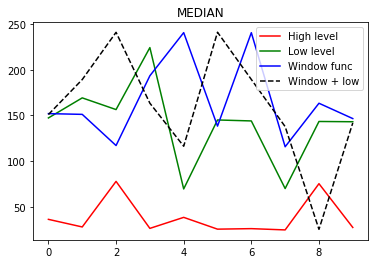

In [27]:
plt.plot(range(10), med1_time, 'r', label='High level')
plt.plot(range(10), med2_time, 'g', label='Low level')
plt.plot(range(10), med3_time, 'b', label='Window func')
plt.plot(range(10), med4_time, 'k--', label='Window + low')
plt.title('MEDIAN')
plt.legend()
plt.show()

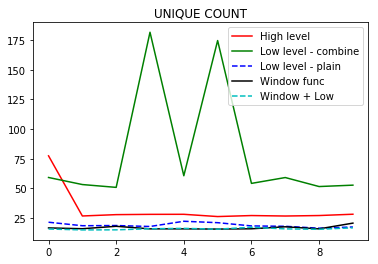

In [28]:
plt.plot(range(10), uniq1_time, 'r', label='High level')
plt.plot(range(10), uniq2_time, 'g', label='Low level - combine')
plt.plot(range(10), uniq3_time, 'b--', label='Low level - plain')
plt.plot(range(10), uniq4_time, 'k', label='Window func')
plt.plot(range(10), uniq5_time, 'c--', label='Window + Low')
plt.title('UNIQUE COUNT')
plt.legend()
plt.show()

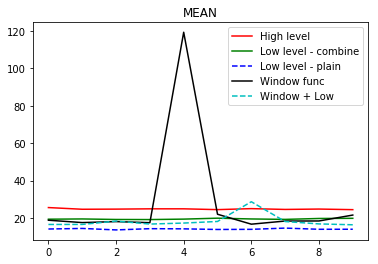

In [29]:
plt.plot(range(10), mean1_time, 'r', label='High level')
plt.plot(range(10), mean2_time, 'g', label='Low level - combine')
plt.plot(range(10), mean3_time, 'b--', label='Low level - plain')
plt.plot(range(10), mean4_time, 'k', label='Window func')
plt.plot(range(10), mean5_time, 'c--', label='Window + Low')
plt.title('MEAN')
plt.legend()
plt.show()

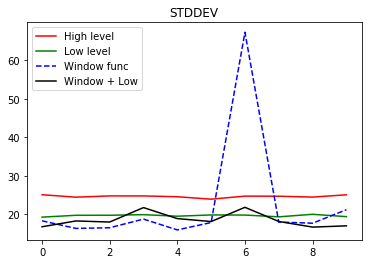

In [30]:
plt.plot(range(10), std1_time, 'r', label='High level')
plt.plot(range(10), std2_time, 'g', label='Low level')
plt.plot(range(10), std3_time, 'b--', label='Window func')
plt.plot(range(10), std4_time, 'k', label='Window + Low')
plt.title('STDDEV')
plt.legend()
plt.show()

In [ ]:
spark.stop()